In [2]:
%pip install -r requirements.txt
%pip install scikit-learn

import sklearn as sk  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#load the datasets from the .npy files
circle_data   = np.load('Data/circle.npy')  
square_data   = np.load('Data/square.npy')
triangle_data = np.load('Data/triangle.npy')
hexagon_data  = np.load('Data/hexagon.npy')
octagon_data  = np.load('Data/octagon.npy')

#label the datasets
circle_labels   = np.full(len(circle_data),   0)
square_labels   = np.full(len(square_data),   1)
triangle_labels = np.full(len(triangle_data), 2)
hexagon_labels  = np.full(len(hexagon_data),  3)
octagon_labels  = np.full(len(octagon_data),  4)
CLASS_NAMES = np.array(['circle', 'square', 'triangle', 'hexagon', 'octagon'])
NUM_CLASSES = len(CLASS_NAMES)

#combine the datasets
X = np.concatenate([circle_data, square_data, triangle_data,
                    hexagon_data, octagon_data], axis=0)
y = np.concatenate([circle_labels, square_labels, triangle_labels,
                    hexagon_labels, octagon_labels], axis=0)

In [9]:
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

#Reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

#One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 5)
y_test  = tf.keras.utils.to_categorical(y_test,  5)

#Reshape the data
X_train = np.expand_dims(X_train, axis=-1)
X_test  = np.expand_dims(X_test,  axis=-1)




In [12]:
#Create the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,997 (363.27 KB)

 Trainable params: 92,997 (363.27 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/10
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - accuracy: 0.8167 - loss: 0.4324 - val_accuracy: 0.8724 - val_loss: 0.3058
Epoch 2/10
2691/8414 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8737 - loss: 0.3019

KeyboardInterrupt: 

In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

model.save("shape_model.h5")
print("Model saved as shape_model.h5")

4207/4207 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8745 - loss: 0.2998


Test Accuracy: 0.8743
Model saved as shape_model.h5


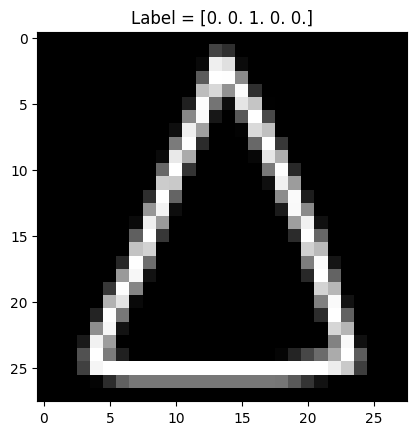

In [23]:
import matplotlib.pyplot as plt

index = 6
plt.imshow(X_train[index].squeeze(), cmap='gray')
plt.title(f"Label = {y_train[index]}")
plt.show()

In [24]:
# Example quick check
import numpy as np

preds = model.predict(X_test[:10])
pred_classes = np.argmax(preds, axis=1)
print("Predicted:", pred_classes)
print("True labels:", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: [4 3 0 0 3 4 0 1 2 1]
True labels: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
